# CE-40550: Machine Learning for Bioinformatic
## HW5 - Generative Adversarial Networks
#### 34 Points

---

Name: AmirHossein Mohammadi

Student No.: 99201081

---

### 1) Importing Libraries

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline

### 2) Auxiliary Modules
These are some useful modules that you can use. Please read them carefully and use them wherever you need.

In [ ]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

### 3) Helper Functions

In [ ]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(int(start[dim]), int(end[dim]), steps))
  result = torch.stack(result, dim=1).to(device)
  return result
  
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows)
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

def mnist_visulization_helper_fn(trainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

def show_interpolations1(trainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    print(anchor_noises.shape)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, 100,1,1)
    print(noises.shape)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

### 4) Importing Dataset

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
BATCH_SIZE = 256
device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')


mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1
                                     ])
}

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 4,
    'shuffle': True
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)


mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler= None, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler= None, **mnist_dataloader_kwargs)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


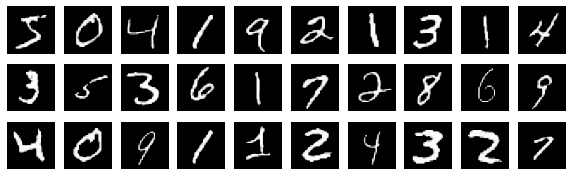

In [ ]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

In [ ]:
mnist_test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f42b9d74dd0>
           )

### 5) Defining Models (6 points)
In this section you are going to define generator and discriminator models. Also you should define a module to generate noise.

In [ ]:
# Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_noise_generator = NoiseGenerator(z_dim=(100,1,1))#64
mnist_reshape=Reshape(new_shape=(1,28,28))

mnist_generator = nn.Sequential(
          nn.ConvTranspose2d(100,28*4,4,1,0, bias=False),
          nn.BatchNorm2d(28*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(28*4,28*2, kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(28*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(28*2, 28, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(28),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(28, 1, kernel_size=4, stride=2, padding=1, bias=False),
          nn.Tanh()
       
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `mnist_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_discriminator = nn.Sequential(
            nn.Conv2d(1,28,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
                
            nn.Conv2d(28,28* 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(28* 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(28* 2, 28* 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(28* 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(1792,1)

       
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): ConvTranspose2d(100, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(112, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(56, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Sequential(
  (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(56, eps=1e-05, mom

### 6) Training Loop (14 points)
In this section you are going to complete the training loop structure code.  

In [ ]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments:
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch.
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`.
  `generator`: The generator.
  `discriminator`: The discriminator. The last layer is a LINEAR layer.
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    self.opt_G = optim.Adam(self.generator.parameters(),lr=G_lr)
    self.opt_D = optim.Adam(self.discriminator.parameters(),lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = self.noise_generator(n)
    fake_samples = self.generator(noise) 
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    noise,x_fake =self.generate_samples(n)
    logits = self.discriminator(x_fake)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      criterion = torch.log(torch.sigmoid(logits))*-1
      loss=torch.rand(1,requires_grad=True)  
      loss = torch.mean(criterion)
    
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      criterion =torch.log(1-torch.sigmoid(logits))*-1
      loss=torch.rand(1,requires_grad=True)
      loss = torch.mean(criterion)
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. n is equal to length of real samples
    #  put them in `x_fake`
    # 2) Detach the generated samples.
    ####################################################
    noise,x_fake = self.generate_samples(len(x_real))
    x_fake=x_fake.detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################
    real=self.discriminator(x_real)
    fake=self.discriminator(x_fake)
    loss=torch.rand(1,requires_grad=True)
    loss = torch.mean(torch.log(torch.sigmoid(real))+torch.log(1-torch.sigmoid(fake)))*-1
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)

      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` and `discriminator` in appropriate mode
        # 2) Zero out `opt_D`'s gradients
        # 3) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 4) Backpropagate `D_loss`
        # 5) Update ``discriminator` parameters
        ####################################################
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` and `discriminator` in appropriate mode
        # 2) Zero out `opt_G`'s gradients
        # 3) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 4) Backpropagate `G_loss`
        # 5) Update `generator` parameters
        ####################################################
        self.generator.train()
        self.opt_G.zero_grad()
        G_loss,x_fake = self.G_step(len(x))
        G_loss.backward()
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    
    print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ###################################################
        self.generator.train()
        self.discriminator.eval()
        G_loss,ff = self.G_step(x.shape[0])
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    
    print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times)
        self.test()
        self.visualization_helper_fn(self)   


### 7) Run GAN (10 ponits)


In this section, you will train a GAN for mnist dataset. Tune the learning rates for the generator and the discriminator, choose the loss function for the generator network and determine the number of epochs and the generator and discriminator's update times in each epoch.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train | Epoch: 1 [0/60160]		D-Loss: 0.622202	G-Loss: 0.593970
Train | Epoch: 1 [12800/60160]		D-Loss: 0.091142	G-Loss: 3.245465
Train | Epoch: 1 [25600/60160]		D-Loss: 0.048456	G-Loss: 1.953546
Train | Epoch: 1 [38400/60160]		D-Loss: 0.114440	G-Loss: 2.347457
Train | Epoch: 1 [51200/60160]		D-Loss: 0.143513	G-Loss: 1.899334

====> Train | Epoch: 1 	 | 	Average D-loss: 0.1306 	 | 	Average G-loss: 2.7098
====> Test | Average D-loss: 0.1060 	 | 	Average G-loss: 2.1811


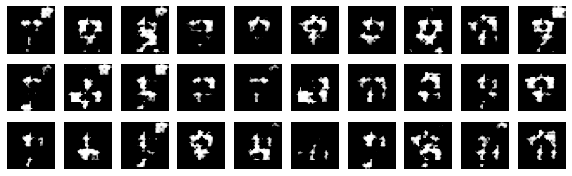

Train | Epoch: 2 [0/60160]		D-Loss: 0.036892	G-Loss: 2.833720
Train | Epoch: 2 [12800/60160]		D-Loss: 0.060584	G-Loss: 2.188313
Train | Epoch: 2 [25600/60160]		D-Loss: 0.113473	G-Loss: 3.052128
Train | Epoch: 2 [38400/60160]		D-Loss: 0.080653	G-Loss: 2.974069
Train | Epoch: 2 [51200/60160]		D-Loss: 0.104512	G-Loss: 2.586271

====> Train | Epoch: 2 	 | 	Average D-loss: 0.1146 	 | 	Average G-loss: 2.8009
====> Test | Average D-loss: 0.4414 	 | 	Average G-loss: 0.9430


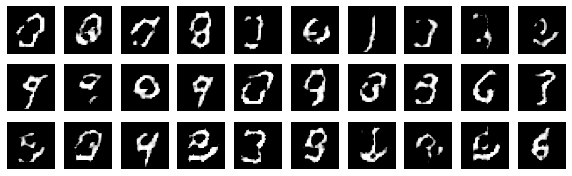

Train | Epoch: 3 [0/60160]		D-Loss: 0.206165	G-Loss: 1.849858
Train | Epoch: 3 [12800/60160]		D-Loss: 0.221787	G-Loss: 2.367198
Train | Epoch: 3 [25600/60160]		D-Loss: 0.184790	G-Loss: 1.105764
Train | Epoch: 3 [38400/60160]		D-Loss: 0.362364	G-Loss: 1.309141
Train | Epoch: 3 [51200/60160]		D-Loss: 0.264881	G-Loss: 1.905656

====> Train | Epoch: 3 	 | 	Average D-loss: 0.2844 	 | 	Average G-loss: 1.8914
====> Test | Average D-loss: 0.8841 	 | 	Average G-loss: 0.7336


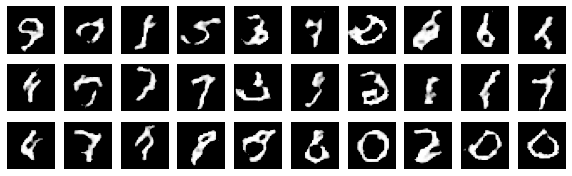

Train | Epoch: 4 [0/60160]		D-Loss: 0.363508	G-Loss: 1.258371
Train | Epoch: 4 [12800/60160]		D-Loss: 0.269370	G-Loss: 2.035715
Train | Epoch: 4 [25600/60160]		D-Loss: 0.421919	G-Loss: 1.285574
Train | Epoch: 4 [38400/60160]		D-Loss: 0.425474	G-Loss: 0.667795
Train | Epoch: 4 [51200/60160]		D-Loss: 0.375389	G-Loss: 1.986354

====> Train | Epoch: 4 	 | 	Average D-loss: 0.3924 	 | 	Average G-loss: 1.6057
====> Test | Average D-loss: 0.6212 	 | 	Average G-loss: 0.9554


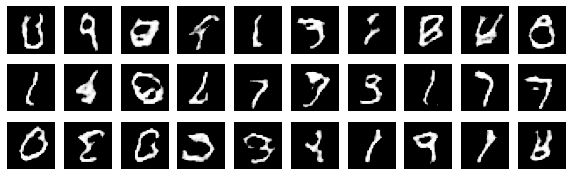

Train | Epoch: 5 [0/60160]		D-Loss: 0.528006	G-Loss: 1.326771
Train | Epoch: 5 [12800/60160]		D-Loss: 0.416727	G-Loss: 2.136103
Train | Epoch: 5 [25600/60160]		D-Loss: 0.721638	G-Loss: 0.796437
Train | Epoch: 5 [38400/60160]		D-Loss: 0.423142	G-Loss: 1.187636
Train | Epoch: 5 [51200/60160]		D-Loss: 0.423666	G-Loss: 1.134135

====> Train | Epoch: 5 	 | 	Average D-loss: 0.4628 	 | 	Average G-loss: 1.4683
====> Test | Average D-loss: 0.8270 	 | 	Average G-loss: 0.9848


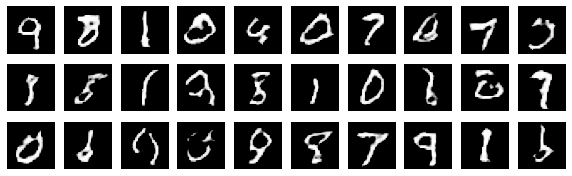

Train | Epoch: 6 [0/60160]		D-Loss: 0.643511	G-Loss: 1.327974
Train | Epoch: 6 [12800/60160]		D-Loss: 0.493838	G-Loss: 1.763775
Train | Epoch: 6 [25600/60160]		D-Loss: 0.512789	G-Loss: 1.030448
Train | Epoch: 6 [38400/60160]		D-Loss: 0.404483	G-Loss: 1.262621
Train | Epoch: 6 [51200/60160]		D-Loss: 0.556807	G-Loss: 1.621914

====> Train | Epoch: 6 	 | 	Average D-loss: 0.4891 	 | 	Average G-loss: 1.4050
====> Test | Average D-loss: 1.0749 	 | 	Average G-loss: 0.4367


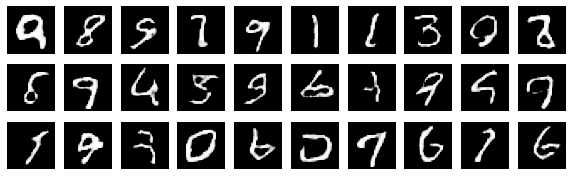

Train | Epoch: 7 [0/60160]		D-Loss: 0.464665	G-Loss: 0.554529
Train | Epoch: 7 [12800/60160]		D-Loss: 0.738103	G-Loss: 0.932537
Train | Epoch: 7 [25600/60160]		D-Loss: 0.485909	G-Loss: 1.416504
Train | Epoch: 7 [38400/60160]		D-Loss: 0.564953	G-Loss: 0.960081
Train | Epoch: 7 [51200/60160]		D-Loss: 0.523374	G-Loss: 1.415901

====> Train | Epoch: 7 	 | 	Average D-loss: 0.5274 	 | 	Average G-loss: 1.3575
====> Test | Average D-loss: 0.8808 	 | 	Average G-loss: 0.6657


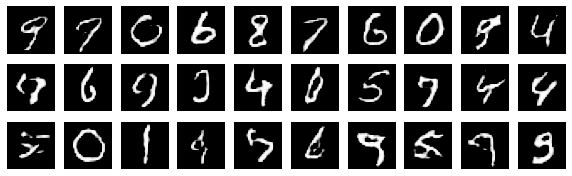

Train | Epoch: 8 [0/60160]		D-Loss: 0.481941	G-Loss: 0.911187
Train | Epoch: 8 [12800/60160]		D-Loss: 0.541928	G-Loss: 1.246854
Train | Epoch: 8 [25600/60160]		D-Loss: 0.437726	G-Loss: 1.594591
Train | Epoch: 8 [38400/60160]		D-Loss: 0.608456	G-Loss: 1.097324
Train | Epoch: 8 [51200/60160]		D-Loss: 0.426718	G-Loss: 1.231707

====> Train | Epoch: 8 	 | 	Average D-loss: 0.5508 	 | 	Average G-loss: 1.3928
====> Test | Average D-loss: 0.6996 	 | 	Average G-loss: 1.2272


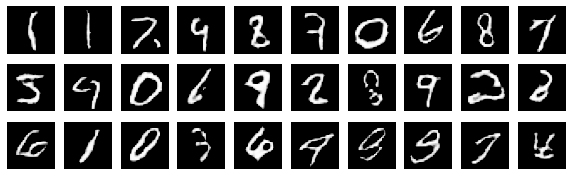

Train | Epoch: 9 [0/60160]		D-Loss: 0.652692	G-Loss: 1.508860
Train | Epoch: 9 [12800/60160]		D-Loss: 0.516482	G-Loss: 1.528048
Train | Epoch: 9 [25600/60160]		D-Loss: 0.539910	G-Loss: 1.218916
Train | Epoch: 9 [38400/60160]		D-Loss: 0.547621	G-Loss: 1.291998
Train | Epoch: 9 [51200/60160]		D-Loss: 0.587408	G-Loss: 1.820115

====> Train | Epoch: 9 	 | 	Average D-loss: 0.5514 	 | 	Average G-loss: 1.3948
====> Test | Average D-loss: 0.7760 	 | 	Average G-loss: 0.9971


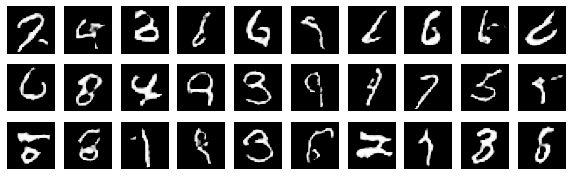

Train | Epoch: 10 [0/60160]		D-Loss: 0.507936	G-Loss: 1.631417
Train | Epoch: 10 [12800/60160]		D-Loss: 0.491711	G-Loss: 1.791343
Train | Epoch: 10 [25600/60160]		D-Loss: 0.500962	G-Loss: 1.460167
Train | Epoch: 10 [38400/60160]		D-Loss: 0.452409	G-Loss: 1.133846
Train | Epoch: 10 [51200/60160]		D-Loss: 0.438642	G-Loss: 0.905017

====> Train | Epoch: 10 	 | 	Average D-loss: 0.5529 	 | 	Average G-loss: 1.3073
====> Test | Average D-loss: 0.6513 	 | 	Average G-loss: 1.2579


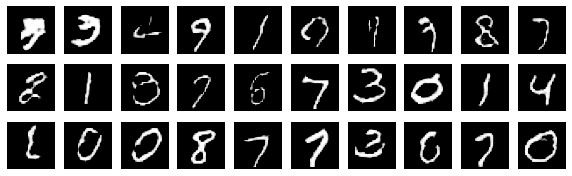

In [ ]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.0002 #0.0002 , 0.005
MNIST_D_LEARNING_RATE = 0.0002 #0.0002
G_LOSS_MODE = 'logD' #logD,log(1-D)
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=10, G_update_times=5, D_update_times=5)
####################### End ########################

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train | Epoch: 1 [0/60160]		D-Loss: 0.254291	G-Loss: 0.818602
Train | Epoch: 1 [12800/60160]		D-Loss: 0.009991	G-Loss: 3.245038
Train | Epoch: 1 [25600/60160]		D-Loss: 0.019216	G-Loss: 4.928096
Train | Epoch: 1 [38400/60160]		D-Loss: 0.105923	G-Loss: 4.936981
Train | Epoch: 1 [51200/60160]		D-Loss: 0.005248	G-Loss: 4.110004

====> Train | Epoch: 1 	 | 	Average D-loss: 0.0310 	 | 	Average G-loss: 3.8192
====> Test | Average D-loss: 0.1330 	 | 	Average G-loss: 0.7600


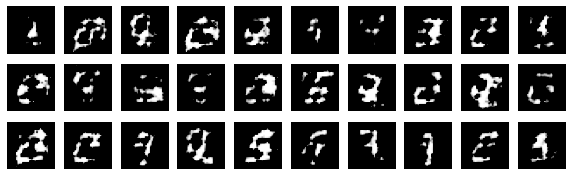

Train | Epoch: 2 [0/60160]		D-Loss: 0.020783	G-Loss: 4.236441
Train | Epoch: 2 [12800/60160]		D-Loss: 0.025271	G-Loss: 3.288188
Train | Epoch: 2 [25600/60160]		D-Loss: 0.034237	G-Loss: 3.172393
Train | Epoch: 2 [38400/60160]		D-Loss: 0.080312	G-Loss: 2.714936
Train | Epoch: 2 [51200/60160]		D-Loss: 0.022969	G-Loss: 2.010320

====> Train | Epoch: 2 	 | 	Average D-loss: 0.0580 	 | 	Average G-loss: 2.7164
====> Test | Average D-loss: 0.3726 	 | 	Average G-loss: 0.4599


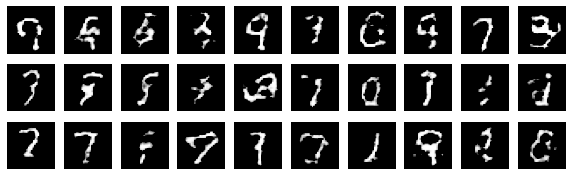

Train | Epoch: 3 [0/60160]		D-Loss: 0.049928	G-Loss: 3.486311
Train | Epoch: 3 [12800/60160]		D-Loss: 0.159176	G-Loss: 3.115885
Train | Epoch: 3 [25600/60160]		D-Loss: 0.080745	G-Loss: 2.588917
Train | Epoch: 3 [38400/60160]		D-Loss: 0.085926	G-Loss: 2.081219
Train | Epoch: 3 [51200/60160]		D-Loss: 0.058655	G-Loss: 1.943342

====> Train | Epoch: 3 	 | 	Average D-loss: 0.1262 	 | 	Average G-loss: 2.3386
====> Test | Average D-loss: 0.2697 	 | 	Average G-loss: 1.6536


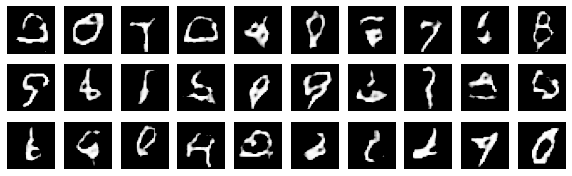

Train | Epoch: 4 [0/60160]		D-Loss: 0.125248	G-Loss: 3.084617
Train | Epoch: 4 [12800/60160]		D-Loss: 0.179650	G-Loss: 1.835547
Train | Epoch: 4 [25600/60160]		D-Loss: 0.074075	G-Loss: 3.601054
Train | Epoch: 4 [38400/60160]		D-Loss: 0.077349	G-Loss: 2.998018
Train | Epoch: 4 [51200/60160]		D-Loss: 0.079948	G-Loss: 3.022759

====> Train | Epoch: 4 	 | 	Average D-loss: 0.0976 	 | 	Average G-loss: 2.9488
====> Test | Average D-loss: 0.2002 	 | 	Average G-loss: 1.4453


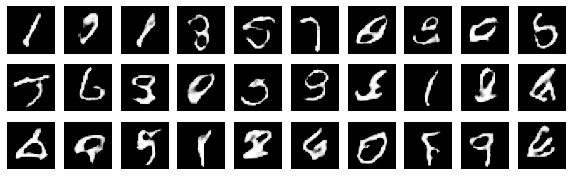

Train | Epoch: 5 [0/60160]		D-Loss: 0.068985	G-Loss: 4.436320
Train | Epoch: 5 [12800/60160]		D-Loss: 0.089168	G-Loss: 3.812887
Train | Epoch: 5 [25600/60160]		D-Loss: 0.121378	G-Loss: 3.872662
Train | Epoch: 5 [38400/60160]		D-Loss: 0.086630	G-Loss: 3.454044
Train | Epoch: 5 [51200/60160]		D-Loss: 0.090951	G-Loss: 3.817323

====> Train | Epoch: 5 	 | 	Average D-loss: 0.0855 	 | 	Average G-loss: 3.1350
====> Test | Average D-loss: 0.4156 	 | 	Average G-loss: 0.8809


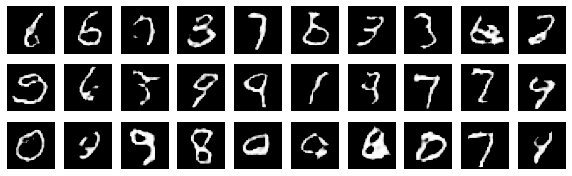

Train | Epoch: 6 [0/60160]		D-Loss: 0.057403	G-Loss: 1.456707
Train | Epoch: 6 [12800/60160]		D-Loss: 0.090608	G-Loss: 3.619745
Train | Epoch: 6 [25600/60160]		D-Loss: 0.087138	G-Loss: 3.502734
Train | Epoch: 6 [38400/60160]		D-Loss: 0.064877	G-Loss: 2.643156
Train | Epoch: 6 [51200/60160]		D-Loss: 0.031973	G-Loss: 2.935331

====> Train | Epoch: 6 	 | 	Average D-loss: 0.0823 	 | 	Average G-loss: 3.2924
====> Test | Average D-loss: 0.2309 	 | 	Average G-loss: 1.7107


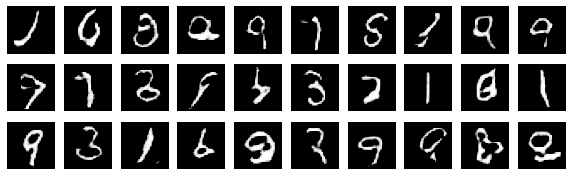

Train | Epoch: 7 [0/60160]		D-Loss: 0.203841	G-Loss: 4.183680
Train | Epoch: 7 [12800/60160]		D-Loss: 0.040033	G-Loss: 3.758803
Train | Epoch: 7 [25600/60160]		D-Loss: 0.040972	G-Loss: 4.395420
Train | Epoch: 7 [38400/60160]		D-Loss: 0.104332	G-Loss: 3.656531
Train | Epoch: 7 [51200/60160]		D-Loss: 0.029054	G-Loss: 3.631218

====> Train | Epoch: 7 	 | 	Average D-loss: 0.0797 	 | 	Average G-loss: 3.5456
====> Test | Average D-loss: 0.2459 	 | 	Average G-loss: 0.5136


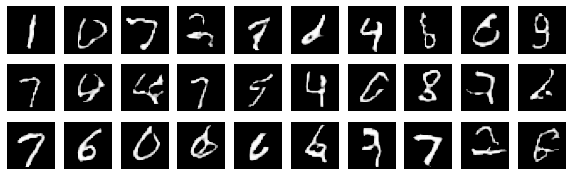

Train | Epoch: 8 [0/60160]		D-Loss: 0.025784	G-Loss: 4.674150
Train | Epoch: 8 [12800/60160]		D-Loss: 0.049283	G-Loss: 3.784990
Train | Epoch: 8 [25600/60160]		D-Loss: 0.101887	G-Loss: 7.045622
Train | Epoch: 8 [38400/60160]		D-Loss: 0.047083	G-Loss: 2.887383
Train | Epoch: 8 [51200/60160]		D-Loss: 0.035923	G-Loss: 3.939618

====> Train | Epoch: 8 	 | 	Average D-loss: 0.0822 	 | 	Average G-loss: 3.5977
====> Test | Average D-loss: 0.1821 	 | 	Average G-loss: 1.1428


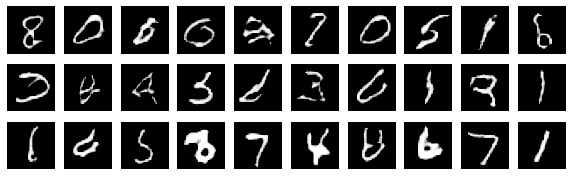

Train | Epoch: 9 [0/60160]		D-Loss: 0.053364	G-Loss: 4.222833
Train | Epoch: 9 [12800/60160]		D-Loss: 0.049256	G-Loss: 3.437685
Train | Epoch: 9 [25600/60160]		D-Loss: 0.089576	G-Loss: 3.108998
Train | Epoch: 9 [38400/60160]		D-Loss: 0.068077	G-Loss: 1.830648
Train | Epoch: 9 [51200/60160]		D-Loss: 0.072003	G-Loss: 2.658895

====> Train | Epoch: 9 	 | 	Average D-loss: 0.0708 	 | 	Average G-loss: 3.5783
====> Test | Average D-loss: 0.2384 	 | 	Average G-loss: 2.6204


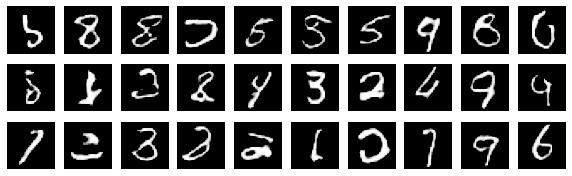

Train | Epoch: 10 [0/60160]		D-Loss: 0.080160	G-Loss: 3.952935
Train | Epoch: 10 [12800/60160]		D-Loss: 0.099347	G-Loss: 3.903150
Train | Epoch: 10 [25600/60160]		D-Loss: 0.045039	G-Loss: 4.286685
Train | Epoch: 10 [38400/60160]		D-Loss: 0.060732	G-Loss: 5.008759
Train | Epoch: 10 [51200/60160]		D-Loss: 0.058326	G-Loss: 4.005529

====> Train | Epoch: 10 	 | 	Average D-loss: 0.0744 	 | 	Average G-loss: 3.7082
====> Test | Average D-loss: 0.1692 	 | 	Average G-loss: 0.8990


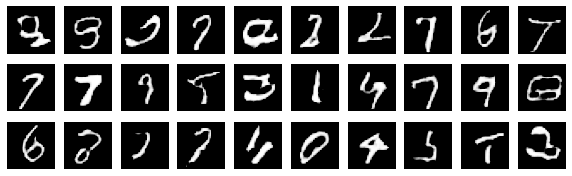

In [ ]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.0002 #0.0002 , 0.005
MNIST_D_LEARNING_RATE = 0.0002 #0.0002
G_LOSS_MODE = 'logD' #logD,log(1-D)
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=10, G_update_times=5, D_update_times=10)
####################### End ########################

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train | Epoch: 1 [0/60160]		D-Loss: 0.934903	G-Loss: 2.143024
Train | Epoch: 1 [12800/60160]		D-Loss: 0.129060	G-Loss: 4.006861
Train | Epoch: 1 [25600/60160]		D-Loss: 0.071462	G-Loss: 3.056424
Train | Epoch: 1 [38400/60160]		D-Loss: 0.047280	G-Loss: 4.298740
Train | Epoch: 1 [51200/60160]		D-Loss: 0.030911	G-Loss: 4.267416

====> Train | Epoch: 1 	 | 	Average D-loss: 0.1202 	 | 	Average G-loss: 4.0904
====> Test | Average D-loss: 0.1766 	 | 	Average G-loss: 3.5209


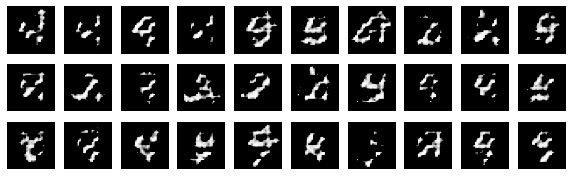

Train | Epoch: 2 [0/60160]		D-Loss: 0.108859	G-Loss: 2.109901
Train | Epoch: 2 [12800/60160]		D-Loss: 0.089233	G-Loss: 4.042191
Train | Epoch: 2 [25600/60160]		D-Loss: 0.074607	G-Loss: 3.763255
Train | Epoch: 2 [38400/60160]		D-Loss: 0.108585	G-Loss: 3.276002
Train | Epoch: 2 [51200/60160]		D-Loss: 0.094331	G-Loss: 1.921497

====> Train | Epoch: 2 	 | 	Average D-loss: 0.0910 	 | 	Average G-loss: 3.6786
====> Test | Average D-loss: 0.2541 	 | 	Average G-loss: 1.0482


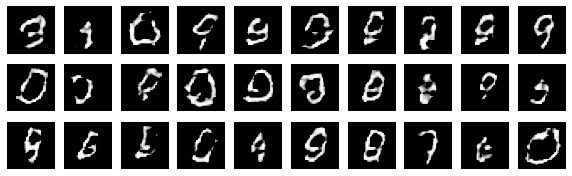

Train | Epoch: 3 [0/60160]		D-Loss: 0.123161	G-Loss: 4.319455
Train | Epoch: 3 [12800/60160]		D-Loss: 0.191286	G-Loss: 3.465725
Train | Epoch: 3 [25600/60160]		D-Loss: 0.187854	G-Loss: 2.364760
Train | Epoch: 3 [38400/60160]		D-Loss: 0.170812	G-Loss: 2.740693
Train | Epoch: 3 [51200/60160]		D-Loss: 0.228501	G-Loss: 4.389441

====> Train | Epoch: 3 	 | 	Average D-loss: 0.1688 	 | 	Average G-loss: 3.2558
====> Test | Average D-loss: 0.2798 	 | 	Average G-loss: 2.5558


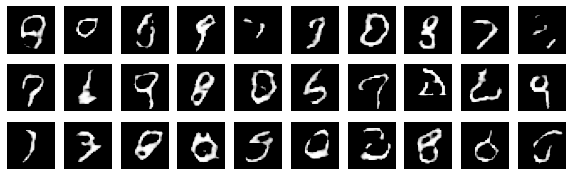

Train | Epoch: 4 [0/60160]		D-Loss: 0.245409	G-Loss: 3.080343
Train | Epoch: 4 [12800/60160]		D-Loss: 0.202176	G-Loss: 4.041705
Train | Epoch: 4 [25600/60160]		D-Loss: 0.214885	G-Loss: 4.299656
Train | Epoch: 4 [38400/60160]		D-Loss: 0.268735	G-Loss: 3.162407
Train | Epoch: 4 [51200/60160]		D-Loss: 0.199766	G-Loss: 3.088593

====> Train | Epoch: 4 	 | 	Average D-loss: 0.2167 	 | 	Average G-loss: 3.2025
====> Test | Average D-loss: 0.2381 	 | 	Average G-loss: 2.2304


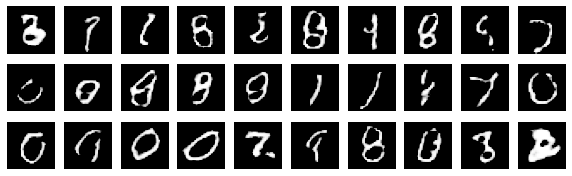

Train | Epoch: 5 [0/60160]		D-Loss: 0.197663	G-Loss: 4.174037
Train | Epoch: 5 [12800/60160]		D-Loss: 0.167486	G-Loss: 3.332052
Train | Epoch: 5 [25600/60160]		D-Loss: 0.102998	G-Loss: 2.131446
Train | Epoch: 5 [38400/60160]		D-Loss: 0.149847	G-Loss: 4.584976
Train | Epoch: 5 [51200/60160]		D-Loss: 0.110269	G-Loss: 3.398195

====> Train | Epoch: 5 	 | 	Average D-loss: 0.1757 	 | 	Average G-loss: 3.3723
====> Test | Average D-loss: 0.2299 	 | 	Average G-loss: 2.4391


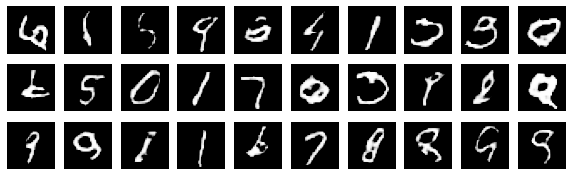

Train | Epoch: 6 [0/60160]		D-Loss: 0.233517	G-Loss: 3.186036
Train | Epoch: 6 [12800/60160]		D-Loss: 0.184817	G-Loss: 2.421815
Train | Epoch: 6 [25600/60160]		D-Loss: 0.152887	G-Loss: 3.895200
Train | Epoch: 6 [38400/60160]		D-Loss: 0.161621	G-Loss: 1.954640
Train | Epoch: 6 [51200/60160]		D-Loss: 0.119982	G-Loss: 3.327715

====> Train | Epoch: 6 	 | 	Average D-loss: 0.1565 	 | 	Average G-loss: 3.4778
====> Test | Average D-loss: 0.1471 	 | 	Average G-loss: 1.7726


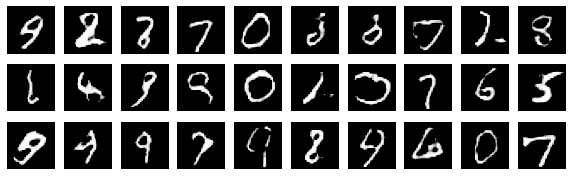

Train | Epoch: 7 [0/60160]		D-Loss: 0.184485	G-Loss: 3.571301
Train | Epoch: 7 [12800/60160]		D-Loss: 0.144513	G-Loss: 4.366810
Train | Epoch: 7 [25600/60160]		D-Loss: 0.090768	G-Loss: 3.684447
Train | Epoch: 7 [38400/60160]		D-Loss: 0.159529	G-Loss: 3.903944
Train | Epoch: 7 [51200/60160]		D-Loss: 0.120684	G-Loss: 2.896487

====> Train | Epoch: 7 	 | 	Average D-loss: 0.1593 	 | 	Average G-loss: 3.6191
====> Test | Average D-loss: 0.1589 	 | 	Average G-loss: 1.2599


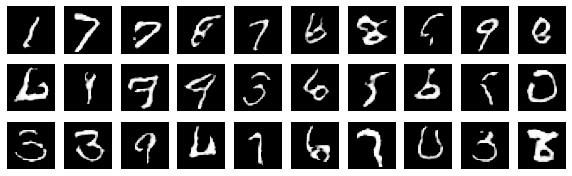

Train | Epoch: 8 [0/60160]		D-Loss: 0.104051	G-Loss: 3.077998
Train | Epoch: 8 [12800/60160]		D-Loss: 0.104911	G-Loss: 5.073825
Train | Epoch: 8 [25600/60160]		D-Loss: 0.146732	G-Loss: 4.140418
Train | Epoch: 8 [38400/60160]		D-Loss: 0.152951	G-Loss: 5.249250
Train | Epoch: 8 [51200/60160]		D-Loss: 0.167581	G-Loss: 3.479688

====> Train | Epoch: 8 	 | 	Average D-loss: 0.1626 	 | 	Average G-loss: 3.7252
====> Test | Average D-loss: 0.2459 	 | 	Average G-loss: 0.8566


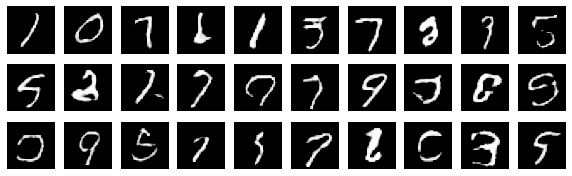

Train | Epoch: 9 [0/60160]		D-Loss: 0.168464	G-Loss: 3.347336
Train | Epoch: 9 [12800/60160]		D-Loss: 0.095972	G-Loss: 3.809616
Train | Epoch: 9 [25600/60160]		D-Loss: 0.109124	G-Loss: 4.028714
Train | Epoch: 9 [38400/60160]		D-Loss: 0.099379	G-Loss: 2.396864
Train | Epoch: 9 [51200/60160]		D-Loss: 0.122090	G-Loss: 3.472835

====> Train | Epoch: 9 	 | 	Average D-loss: 0.1561 	 | 	Average G-loss: 3.4701
====> Test | Average D-loss: 0.2262 	 | 	Average G-loss: 0.8382


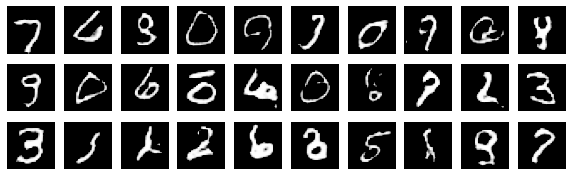

Train | Epoch: 10 [0/60160]		D-Loss: 0.195488	G-Loss: 1.782380
Train | Epoch: 10 [12800/60160]		D-Loss: 0.112614	G-Loss: 4.858526
Train | Epoch: 10 [25600/60160]		D-Loss: 0.107182	G-Loss: 3.028969
Train | Epoch: 10 [38400/60160]		D-Loss: 0.107296	G-Loss: 3.627926
Train | Epoch: 10 [51200/60160]		D-Loss: 0.103174	G-Loss: 2.828745

====> Train | Epoch: 10 	 | 	Average D-loss: 0.1517 	 | 	Average G-loss: 3.7227
====> Test | Average D-loss: 0.2049 	 | 	Average G-loss: 2.3319


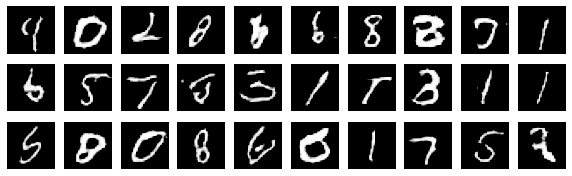

In [ ]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.0002 #0.0002 , 0.005
MNIST_D_LEARNING_RATE = 0.0002 #0.0002
G_LOSS_MODE = 'logD' #logD,log(1-D)
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=10, G_update_times=10, D_update_times=5)
####################### End ########################

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train | Epoch: 1 [0/60160]		D-Loss: 0.000047	G-Loss: 0.012345
Train | Epoch: 1 [12800/60160]		D-Loss: 0.585962	G-Loss: 0.295787
Train | Epoch: 1 [25600/60160]		D-Loss: 0.475246	G-Loss: 0.447997
Train | Epoch: 1 [38400/60160]		D-Loss: 0.513974	G-Loss: 0.493730
Train | Epoch: 1 [51200/60160]		D-Loss: 0.215956	G-Loss: 0.210117

====> Train | Epoch: 1 	 | 	Average D-loss: 0.3612 	 | 	Average G-loss: 0.3918



====> Test | Average D-loss: 1.8556 	 | 	Average G-loss: 0.2277


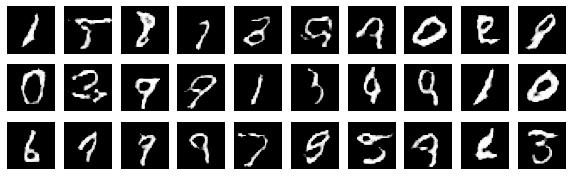

Train | Epoch: 2 [0/60160]		D-Loss: 0.170197	G-Loss: 0.224610
Train | Epoch: 2 [12800/60160]		D-Loss: 0.504131	G-Loss: 0.973254
Train | Epoch: 2 [25600/60160]		D-Loss: 0.242507	G-Loss: 0.235116
Train | Epoch: 2 [38400/60160]		D-Loss: 0.318596	G-Loss: 0.664339
Train | Epoch: 2 [51200/60160]		D-Loss: 0.107087	G-Loss: 0.306019

====> Train | Epoch: 2 	 | 	Average D-loss: 0.2999 	 | 	Average G-loss: 0.6228



====> Test | Average D-loss: 1.5791 	 | 	Average G-loss: 0.7295


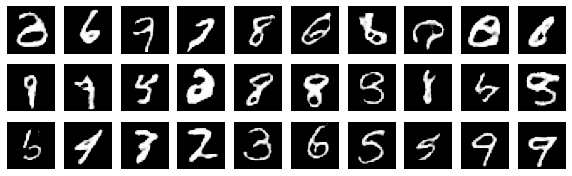

Train | Epoch: 3 [0/60160]		D-Loss: 0.115248	G-Loss: 0.474221
Train | Epoch: 3 [12800/60160]		D-Loss: 0.299434	G-Loss: 1.472134
Train | Epoch: 3 [25600/60160]		D-Loss: 0.146500	G-Loss: 0.746454


KeyboardInterrupt: ignored

In [ ]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.0002 #0.0002 , 0.005
MNIST_D_LEARNING_RATE = 0.0002 #0.0002
G_LOSS_MODE = 'logD' #logD,log(1-D)
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=10, G_update_times=35, D_update_times=25)
####################### End ########################

Question 1) What will happen if the number of updates of discriminator network is much higher than the number of updates of generator network in each epoch? (2 points)

Your answer:

Question 2) What will happen if the number of updates of generator network is much higher than the number of updates of discriminator network in each epoch? (2 points)

Your answer:

You can write your answers in persian.

### 8) Final Visualization

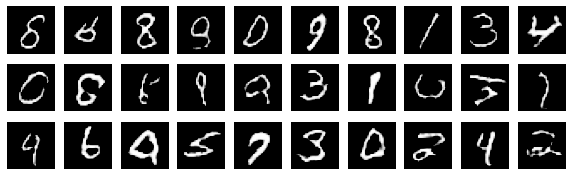

In [ ]:
mnist_visulization_helper_fn(mnist_trainer)

### 10) Interpolation (4 points)

In [ ]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(int(start[dim]), int(end[dim]), steps,requires_grad=True))
  result = torch.stack(result, dim=1).to(device)
  return result
  
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows)
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

def mnist_visulization_helper_fn(trainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

def show_interpolations(trainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, 100,1,1)
    #print(noises.shape)
    #noises=mnist_trainer.noise_generator(100)
    #print(noises.shape)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

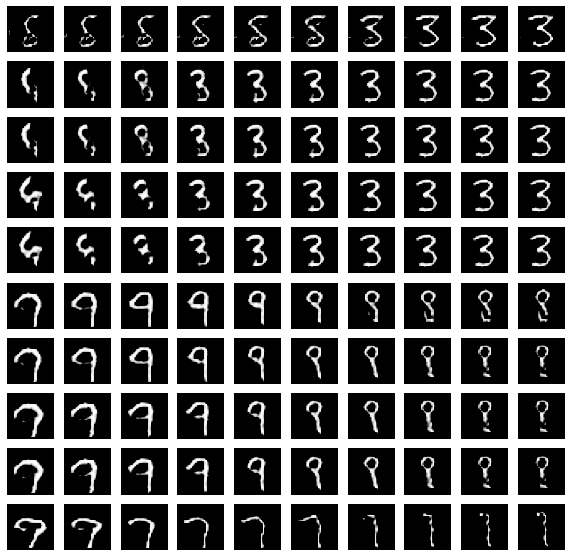

In [ ]:
show_interpolations(mnist_trainer, 10, 10)